# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

# Usefull functions

In [2]:
# Define a function to map values to colors
def map_to_color(x, y, z, df):
    # Check if there's variance to avoid division by zero
    r = x / df['x'].max() if df['x'].max() != 0 else 0  # Red component based on 'x'
    g = y / df['y'].max() if df['y'].max() != 0 else 0  # Green component based on 'y'
    b = z / df['z'].max() if df['z'].max() != 0 else 0  # Blue component based on 'z'
    
    return (r, g, b)

# Parse variables

In [3]:
from scripts.parse_vars import parse_variables

In [4]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])
commands = [
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    f'setwd("{R_directory}")',
    f'source("{R_file}", echo=TRUE)'
]


# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)


# create Genotype

In [5]:
df = pd.read_csv(f"{R_directory}/simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv")
os.system(f"rm -rf {R_directory}/simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv")
df["populations"] = [i+1 for i in range(k*k) for _ in range(c)]

In [6]:
complete = []

unique_pops = df['populations'].unique()
snp_cols = df.columns[:-1]  # Assumes 'populations' is the last column

for pop in unique_pops:
    pop_df = df[df['populations'] == pop]

    # Flip one random genotype per SNP
    for col in snp_cols:
        idx = np.random.choice(pop_df.index)
        pop_df.loc[idx, col] = 1 - pop_df.loc[idx, col]  # Flip 0↔1

    # Estimate MAF q
    q_values = pop_df[snp_cols].mean()

    # Simulate genotypes
    n_individuals = len(pop_df)
    genotype_matrix = np.zeros((n_individuals, len(snp_cols)), dtype=int)
    
    for i, snp in enumerate(snp_cols):
        q = q_values[snp]
        p = 1 - q
        probs = np.array([q**2 + F*p*q, 2*p*q*(1 - F), p**2 + F*p*q])
        probs /= probs.sum()
        genotype_matrix[:, i] = np.random.choice([-1, 0, 1], size=n_individuals, p=probs)

    pop_df.loc[:, snp_cols] = genotype_matrix
    complete.append(pop_df)

# Combine all populations
complete = pd.concat(complete, ignore_index=True)
N = len(complete)

# Flip alleles so that MAF <= 0.5 and compute MAFs
maf_values = {}
for snp in snp_cols:
    genos = complete[snp]
    maf = (2 * (genos == -1).sum() + (genos == 0).sum()) / (2 * N)
    if maf > 0.5:
        complete[snp] = genos.replace({-1: 1, 1: -1})
        maf = 1 - maf
    maf_values[snp] = maf

# Sort SNPs by descending MAF
sorted_snps = sorted(maf_values.items(), key=lambda x: x[1], reverse=True)

# Create new column names: V1_MAF_0.489, etc.
new_col_names = {}
for i, (snp, maf) in enumerate(sorted_snps):
    new_name = f"{i+1}_MAF_{maf:.3f}"
    new_col_names[snp] = new_name

# Rename and reorder SNP columns
complete.rename(columns=new_col_names, inplace=True)
ordered_cols = list(new_col_names.values()) + ['populations']
complete = complete[ordered_cols]

In [7]:
humans = complete[['populations']]
complete = complete.drop(columns = ['populations'])

# Create population labels

In [8]:
humans = humans.copy()
# Convert and calculate coordinates safely using .loc
humans.loc[:, 'populations'] = humans['populations'].astype(int)
humans.loc[:, 'x'] = ((humans['populations'] - 1) % k) + 1
humans.loc[:, 'y'] = ((humans['populations'] - 1) // k) + 1
humans.loc[:, 'z'] = F
humans.loc[:, 'population'] = humans['populations'] / (k * k)


In [9]:
# Sort columns by MAF
# Initialize lists to hold the DataFrames
very_rare_cols = []
rare_cols = []
common_cols = []

# Categorize columns based on allele frequency
for col in complete.columns:
    af_value = float(col.split('_')[2])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]].rename(columns={col: 'VR_' + col}))
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]].rename(columns={col: 'R_' + col}))
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]].rename(columns={col: 'C_' + col}))

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)

# Vizualize populations through PCA

In [10]:
try:
    scaler = StandardScaler()
    scaled_complete = scaler.fit_transform(complete)
    n_components = max(min(complete.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_complete = pca.fit_transform(scaled_complete)
    PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

except:
    print("nothing in complete")
    PC_complete = pd.DataFrame(np.zeros((len(complete), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_common = scaler.fit_transform(common)
    n_components = max(min(common.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_common = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_common = pca.fit_transform(scaled_common)
    PC_common = pd.DataFrame(data=PC_common, columns=pc_labels_common)
except:
    print("common is empty")
    PC_common = pd.DataFrame(np.zeros((len(common), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_rare = scaler.fit_transform(rare)
    n_components = max(min(rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_rare = pca.fit_transform(scaled_rare)
    PC_rare = pd.DataFrame(data=PC_rare, columns=pc_labels_rare)
except:
    print("rare is empty")
    PC_rare = pd.DataFrame(np.zeros((len(rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_veryrare = scaler.fit_transform(very_rare)
    n_components = max(min(very_rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_very_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_veryrare = pca.fit_transform(scaled_veryrare)
    PC_veryrare = pd.DataFrame(data=PC_veryrare, columns=pc_labels_very_rare)
except:
    print("very rare is empty")
    PC_veryrare = pd.DataFrame(np.zeros((len(very_rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [11]:
to_have_collumns = ['populations', 'x', 'y', 'population']
PC_complete[to_have_collumns] = humans[to_have_collumns]
PC_common[to_have_collumns] = humans[to_have_collumns]
PC_rare[to_have_collumns] = humans[to_have_collumns]
PC_veryrare[to_have_collumns] = humans[to_have_collumns]

In [12]:
number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

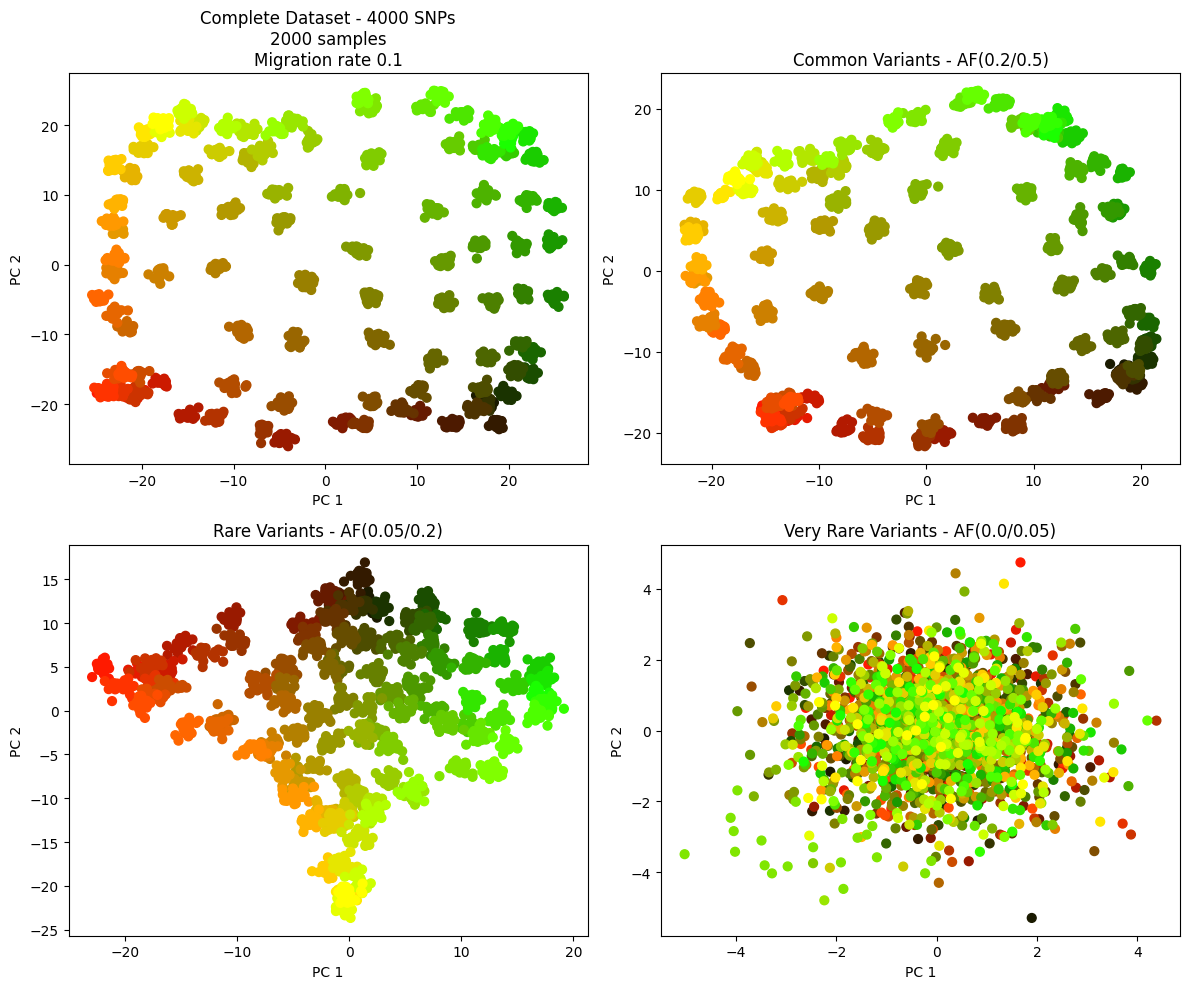

In [13]:
# Generate color mapping for the 'humans' DataFrame
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

# Save data

In [14]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)

In [15]:
complete.to_pickle(f"{path_geno}/complete_inbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")